In [9]:
import torch
import numpy as np
import torchvision
import torch.nn as nn
from torch.utils.data.dataset import Dataset
from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn.functional as F

In [10]:
class Network(nn.Module):
    
    def __init__(self):

        super().__init__()

        # sees 32, 32, 3
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         self.batch_norm1 = nn.BatchNorm2d(16)
        
        # sees 16, 16, 64
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.batch_norm2 = nn.BatchNorm2d(32)
        
        # sees 8, 8, 128
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
#         self.batch_norm3 = nn.BatchNorm2d(64)

        # dropout layer
        self.drop_out = nn.Dropout(0.25)
        
        # will get flattened and sees 4, 4, 64
        self.fc1 = nn.Linear(4*4*64, 500)
        self.fc2 = nn.Linear(500, 10)
        
        self.max_pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Softmax(dim=1)
        
#         self.batch_norm_fc1 = nn.BatchNorm1d(4000)

    def forward(self, x):

#         x = self.max_pool(F.relu(self.batch_norm1(self.conv1(x))))
#         x = F.relu(self.batch_norm2(self.conv2(x)))
#         x = F.relu(self.batch_norm3(self.conv3(x)))
        
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.max_pool(F.relu(self.conv3(x)))
        
        # flatten
        x = x.view(-1, 4*4*64)
        
        x = self.drop_out(x)
        x = F.relu(self.fc1(x))
        
        x = self.drop_out(x)      
        x = self.fc2(x)
#         x = self.softmax(x)

        return x

In [11]:
# load CIFAR image data

In [12]:
BATCH_SIZE = 50

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [13]:
# create network object
model = Network()

In [14]:
# define the optimizer and loss function

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cuda:0'

In [15]:
# move to gpu
model.to(device)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop_out): Dropout(p=0.25)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (softmax): Softmax()
)

In [16]:
# train the model
epochs = 1
total_steps = len(trainloader)
training_losses = []
test_losses = []
train_acc = []
test_acc = []

# loop through epochs
for epoch in range(epochs):
    
    train_running_loss = 0  # track train running loss
    correct = 0
    total = 0
    
    model.train() # set to train mode
    
    # load batch images/labels
    for step, (images, labels) in enumerate(trainloader):
        
        # put data onto available device
        images = images.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
    
        outputs = model(images)  # forward pass
        _, predicted = torch.max(outputs.data, 1)  # retrieve top preds
        
        total += labels.size(0)  # add batch size
        correct += (predicted == labels).sum().item()  # calc num correct
        
        loss = criterion(outputs, labels)  # calc loss
        train_running_loss += loss.item()  # acc running loss
        
        loss.backward()   # backprop
        optimizer.step()  # forward

        if step % 100 == 0:  # print progress by iteration
        
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
            .format(epoch+1, epochs, step+1, total_steps, loss.item()))
    
    # div by num batches to get average
    epoch_train_loss = train_running_loss / len(trainloader)
                   
    print('Epoch [{}/{}], Train Loss: {:.4f}'.format(epoch+1, epochs, epoch_train_loss))
        
    # append the loss/acc after all the steps 
    training_losses.append(epoch_train_loss)
    train_acc.append(correct / total)
        
    
    # ------------------------------ #
    

    # evaluate on test data
    model.eval()
    with torch.no_grad():
        test_running_loss = 0  # track test running loss
        correct = 0
        total = 0

        for images, labels in testloader:
                   
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
                   
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
                   
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
                 
    # div by num batches
    epoch_test_loss = test_running_loss / len(testloader)
                   
    print('Epoch [{}/{}], Test Loss: {:.4f}'.format(epoch+1, epochs, epoch_test_loss))
        
    # append the loss & acc after all the steps 
    test_losses.append(epoch_test_loss)
    test_acc.append(correct / total)
            
    print('Test Accuracy: {} %'.format(100 * correct / total))

Epoch [1/1], Step [1/1000], Loss: 2.3098
Epoch [1/1], Step [101/1000], Loss: 2.2811
Epoch [1/1], Step [201/1000], Loss: 2.2590
Epoch [1/1], Step [301/1000], Loss: 2.2672
Epoch [1/1], Step [401/1000], Loss: 2.1919
Epoch [1/1], Step [501/1000], Loss: 2.0986
Epoch [1/1], Step [601/1000], Loss: 2.0304
Epoch [1/1], Step [701/1000], Loss: 2.2009
Epoch [1/1], Step [801/1000], Loss: 2.1185
Epoch [1/1], Step [901/1000], Loss: 1.9045
Epoch [1/1], Train Loss: 2.1502
Epoch [1/1], Test Loss: 1.9602
Test Accuracy: 29.22 %


In [17]:
def plot_graph(train_losses, test_losses, train_acc, test_acc):
    # plot graph
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train loss")
    plt.plot(test_losses, label="Test loss")
    plt.legend(loc='best')
    plt.title("Loss vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (Cross entropy)")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(test_acc, label="Test Accuracy")
    plt.legend(loc='best')
    plt.title("Accuracy vs Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()
    plt.savefig('part_a_cifar_loss_acc.png')

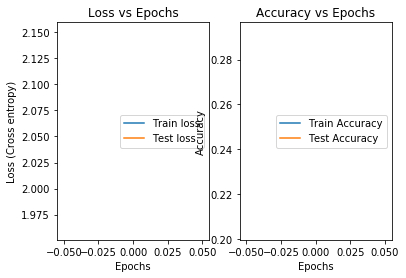

<Figure size 432x288 with 0 Axes>

In [18]:
plot_graph(training_losses, test_losses, train_acc, test_acc)

In [19]:
# retrieve conv1 layer, convert to numpy array, put on cpu first
weights = model.conv1.weight.data.cpu()

In [20]:
# def norm_stretch(filter):
    
#     filter = filter - torch.min(filter)
    
#     return filter / torch.max(filter)

In [29]:
# # plot filters
# def plot_kernels(tensor, num_rows=8, num_cols=8):

#     fig = plt.figure(figsize=(num_cols,num_rows))
    
#     for i in range(tensor.shape[0]):
#         ax1 = fig.add_subplot(num_rows,num_cols,i+1)  
        
#         # need to reshape it to move channels to end
# #         reshaped = tensor[i].view(11,11,3)
    
#         norm_tensor = norm_stretch(tensor[i])
#         reshaped = np.transpose(norm_tensor.numpy(),(2,1,0))
        
        
# #         print(norm_tensor.shape)
        
# #         ax1.imshow(tensor[i])
#         ax1.imshow(norm_tensor)
#         ax1.axis('off')
#         ax1.set_xticklabels([])
#         ax1.set_yticklabels([])
    
# #     plt.subplots_adjust(wspace=0.1, hspace=0.1)
#     plt.savefig('filters_part3b.jpg')
#     plt.show()
#     plt.clf()
    

torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])
torch.Size([3, 3, 3])


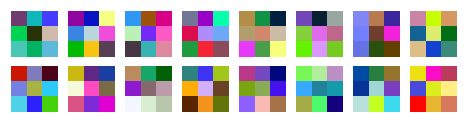

<Figure size 432x288 with 0 Axes>

In [30]:
# plot_kernels(weights)